In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Sobre os dados

Dados extraídos do site de dados abertos do Governo Federal. Devido ao arquivo .csv utilizado ser grande demais para ser armazenado no GitHub, ele não está disponível no repositório do projeto, mas pode ser acessado [aqui](http://dados.gov.br/dataset/serie-historica-de-precos-de-combustiveis-por-revenda). Nele, constam informações sobre a compra e venda de combustíveis automotivos no primeiro semestre de 2019. No ano de 2018, ocorreu no Brasil uma greve generalizada por parte de caminhoneiros, acarretando em falta de muitos produtos, dentre eles, combustíveis automotivos. Um dos objetivos para a presente análise é verificar o preço do combustível pós-greves, para mais tarde, comparar com o período de 2018.

**AVISO**: Os dados e análises foram obtidos para fins de estudo acerca da ciência de dados, ou seja, existem consideráveis chances de estarem imprecisos ou incorretos. Caso tenha alguma sugestão de correção ou melhoria, deixe uma issue ou pull request :)

Questões iniciais:
- Preço médio da gasolina por estado;
- Média do preço da gasolina na cidade de Alegrete;

In [5]:
fuel = pd.read_csv('datasets/cleaned_fuel.csv', sep=';', index_col=0)
fuel.head()

,Região - Sigla,Estado - Sigla,Município,Revenda,CNPJ da Revenda,Produto,Data da Coleta,Valor de Venda,Valor de Compra,Unidade de Medida,Bandeira
0,CO,DF,BRASILIA,ABRITTA POSTOS DE SERVIÇOS LTDA,10668863000195,DIESEL,16/01/2019,3.8,3.22,R$ / litro,RAIZEN
1,CO,DF,BRASILIA,ABRITTA POSTOS DE SERVIÇOS LTDA,10668863000195,DIESEL,23/01/2019,3.8,0.00,R$ / litro,RAIZEN
2,CO,DF,BRASILIA,ABRITTA POSTOS DE SERVIÇOS LTDA,10668863000195,DIESEL S10,16/01/2019,3.9,3.26,R$ / litro,RAIZEN
3,CO,DF,BRASILIA,ABRITTA POSTOS DE SERVIÇOS LTDA,10668863000195,DIESEL S10,23/01/2019,3.9,0.00,R$ / litro,RAIZEN
4,CO,DF,BRASILIA,ABRITTA POSTOS DE SERVIÇOS LTDA,10668863000195,ETANOL,16/01/2019,3.3,3.00,R$ / litro,RAIZEN


## 2. Análise dos dados

Após a limpeza dos dados, podemos começar propriamente o processo de análise. Primeiramente, obteremos um dataframe com todos os estados, que se repetiam cinco vezes, uma para cada tipo de combustível bem como o preço médio. O objetivo é gerar um gráfico comparando o preço médio do litro de cada tipo de combustível em cada estado brasileiro. **Importante**: valores 0 são considerados, para fins de análise, como informação insuficiente para calcular preço médio, provavelmente por ausência do produto na região correspondente.

In [12]:
price_by_state = fuel.filter(items=['Estado - Sigla', 'Produto', 'Valor de Venda'])

states = [x for x in price_by_state['Estado - Sigla'].unique()]
products = [x for x in price_by_state['Produto'].unique()]
prices = []

for state in states:
    for product in products:
        prices.append([state, product, price_by_state[(price_by_state['Estado - Sigla'] == state) & (price_by_state['Produto'] == product)].mean().values[0]])

del price_by_state

price_by_state = pd.DataFrame({'Estado - Sigla': [x[0] for x in prices], 'Produto': [x[1] for x in prices], 'Preço Médio': [x[2] for x in prices]})
price_by_state['Preço Médio'] = price_by_state['Preço Médio'].apply(lambda x: round(x, 2))
price_by_state['Preço Médio'].fillna(0, inplace=True)
price_by_state = price_by_state.pivot("Estado - Sigla", "Produto", "Preço Médio")
price_by_state.to_csv('datasets/price_by_state.csv', sep=';')

price_by_state.head()

Produto,DIESEL,DIESEL S10,ETANOL,GASOLINA,GNV
Estado - Sigla,,,,,
AC,4.43,4.50,4.02,4.92,0.00
AL,3.75,3.82,3.56,4.58,3.43
AM,3.76,3.86,3.41,4.30,3.17
AP,4.12,4.61,3.83,3.97,0.00
BA,3.58,3.66,3.46,4.57,3.14


Text(87.0, 0.5, 'Estado')

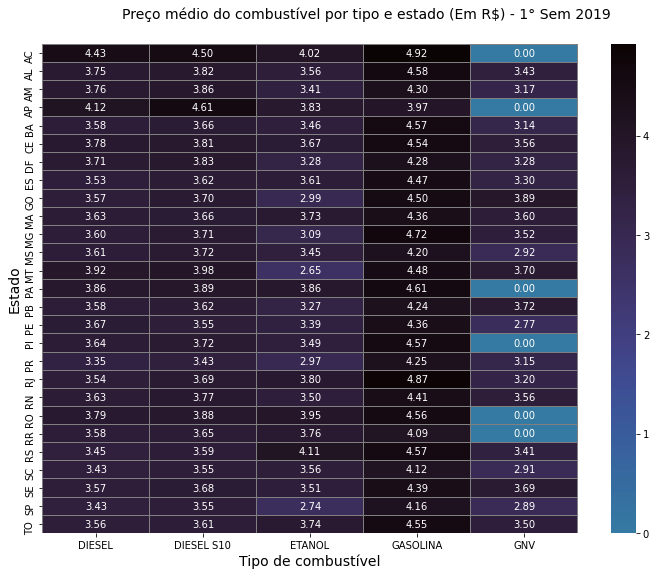

In [20]:
fig, ax = plt.subplots(figsize=(12,9))
sns.heatmap(price_by_state, linewidths=.02, linecolor='gray', cmap="mako_r", annot=True, annot_kws={"fontsize":10}, 
            ax=ax, fmt = '.2f', center = 0)
title = plt.figtext(.5,.9,"Preço médio do combustível por tipo e estado (Em R$) - 1° Sem 2019", fontsize=14, ha="center")
title.set_position([.5, 0.92])
ax.xaxis.set_label_text("Tipo de combustível", fontdict={'size':14})
ax.yaxis.set_label_text("Estado", fontdict={'size':14})

Para o próximo passo, queremos descobrir qual o preço médio da gasolina especificamente na cidade de Alegrete, ao passar do tempo. Para isso, utilizamos os dados de venda para cada revendedor e calculamos a média no dia. Como a coleta não foi totalmente constante o ano inteiro, alguns meses apresentam poucos registros de coleta. É justo validar até que ponto tal fato intefere no resultado.

In [21]:
alegrete_fuel = fuel[(fuel['Município'] == 'ALEGRETE') & (fuel['Produto'] == 'GASOLINA')] \
            .sort_values(by='Data da Coleta') \
            .filter(items=['Data da Coleta', "Valor de Venda"]) \
            .set_index(['Data da Coleta'])

alegrete_fuel.index = pd.to_datetime(alegrete_fuel.index)
alegrete_fuel = alegrete_fuel.groupby('Data da Coleta').agg({'Valor de Venda': np.average})

alegrete_fuel.head()

,Valor de Venda
Data da Coleta,
2019-01-04,4.688571
2019-01-15,4.560000
2019-01-16,4.602000
2019-01-21,4.600000
2019-01-22,4.560000


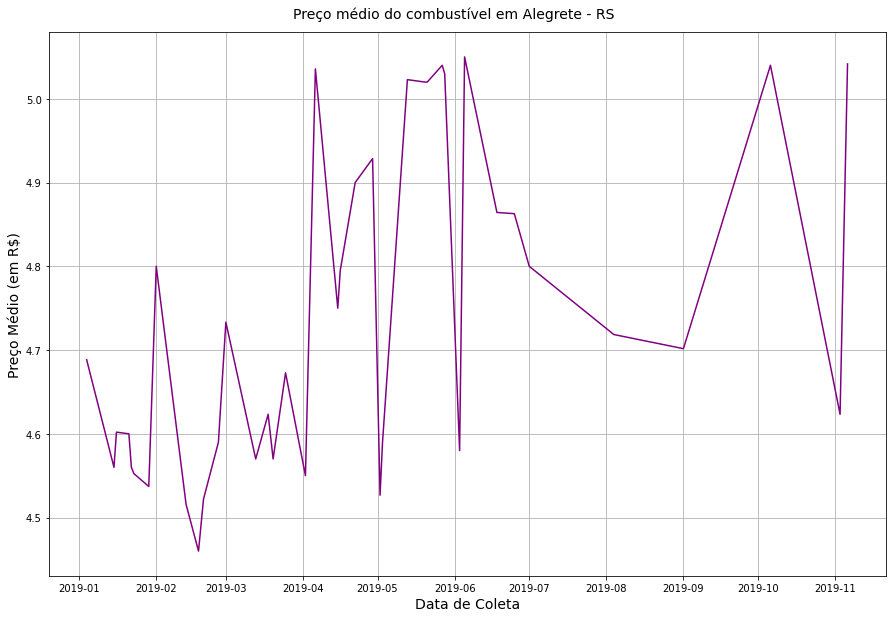

In [24]:
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(alegrete_fuel, color='purple')
plt.grid(True)
plt.xlabel('Data')
title = plt.figtext(.5,.9,"Preço médio do combustível em Alegrete - RS", fontsize=14, ha="center")
ax.xaxis.set_label_text("Data de Coleta", fontdict={'size':14})
ax.yaxis.set_label_text("Preço Médio (em R$)", fontdict={'size':14})
plt.show()